# FastText

FastText是一种典型的深度学习词向量的表示方法，它非常简单通过Embedding层将单词映射到稠密空间，然后将句子中所有的单词在Embedding空间中进行平均，进而完成分类操作。

所以FastText是一个三层的神经网络，输入层、隐含层和输出层。

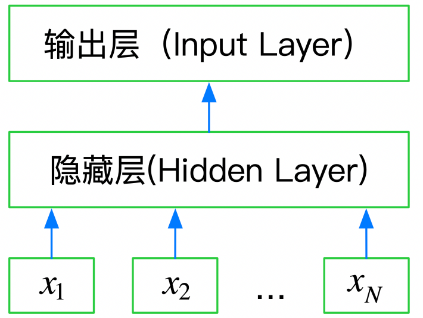

## 学习目标

学习FastText的使用和基础原理

学会使用验证集进行调参

In [1]:
import numpy as np
import pandas as pd
import fasttext
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
train_df = pd.read_csv('./data/train_set.csv', sep='\t', nrows=None)
test_df = pd.read_csv('./data/test_a.csv', sep='\t')

In [3]:
# 转换为FastText需要的格式
train_df['label_ft'] = '__label__' + train_df['label'].astype(str)

In [4]:
train_df['label_ft']

0          __label__2
1         __label__11
2          __label__3
3          __label__2
4          __label__3
             ...     
199995     __label__2
199996     __label__2
199997    __label__11
199998     __label__2
199999     __label__3
Name: label_ft, Length: 200000, dtype: object

In [5]:
train_df['label']

0          2
1         11
2          3
3          2
4          3
          ..
199995     2
199996     2
199997    11
199998     2
199999     3
Name: label, Length: 200000, dtype: int64

In [6]:
# 各个类别性能度量的函数
def category_performance_measure(labels_right, labels_pred):
    text_labels = list(set(labels_right))
    text_pred_labels = list(set(labels_pred))
    
    TP = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
    TP_FP = dict.fromkeys(text_labels,0)   #测试数据集中各个类的数目
    TP_FN = dict.fromkeys(text_labels,0) #预测结果中各个类的数目
    
    # 计算TP等数量
    for i in range(0,len(labels_right)):
        TP_FP[labels_right[i]] += 1
        TP_FN[labels_pred[i]] += 1
        if labels_right[i] == labels_pred[i]:
            TP[labels_right[i]] += 1
    #计算准确率P，召回率R，F1值
    for key in TP_FP:
        P = float(TP[key]) / float(TP_FP[key] + 1)
        R = float(TP[key]) / float(TP_FN[key] + 1)
        F1 = P * R * 2 / (P + R) if (P + R) != 0 else 0
        print("%s:\t P:%f\t R:%f\t F1:%f" % (key,P,R,F1))

In [ ]:
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
KF = KFold(n_splits=5, random_state=7, shuffle=True)
test_pred = np.zeros((X_test.shape[0], 1), int)  # 存储测试集预测结果 行数：len(X_test) ,列数：1列
for KF_index, (train_index,valid_index) in enumerate(KF.split(X_train)):
    print('第', KF_index+1, '折交叉验证开始...')
    train_df[['text','label_ft']].iloc[train_index].to_csv('train_df.csv', header=None, index=False, sep='\t')
    # 模型构建
    model = fasttext.train_supervised('train_df.csv', lr=0.1, epoch=50, wordNgrams=5, 
                                      verbose=2, minCount=1, loss='hs')
    # 模型预测
    val_pred = [int(model.predict(x)[0][0].split('__')[-1]) for x in X_train.iloc[valid_index]]
    print('Fasttext准确率为：',f1_score(list(y_train.iloc[valid_index]), val_pred, average='macro'))
    category_performance_measure(list(y_train.iloc[valid_index]), val_pred)
    
    # 保存测试集预测结果
    test_pred_ = [int(model.predict(x)[0][0].split('__')[-1]) for x in X_test]
    test_pred = np.column_stack((test_pred, test_pred_))  # 将矩阵按列合并
# 取测试集中预测数量最多的数
preds = []
for i, test_list in enumerate(test_pred):
    preds.append(np.argmax(np.bincount(test_list)))
preds = np.array(preds)   

第 1 折交叉验证开始...


In [9]:
submission = pd.read_csv('./data/test_a_sample_submit.csv')
submission['label'] = preds
submission.to_csv('./output/Fasttext_submission.csv', index=False)